## 7. Backtesting

Since we didn't consider prepayment timing and monthly installment, this has not been a precise analysis. From this section, let's run the backtesting to see how our investment evolves over time, and what we can expect from our investment.

We ran the backtest on the one year OOT data from 2016Q3 to 2017Q2. The fitted xgb classification model is used for prediction.

In [11]:
import Data_Helper as DH
import lendingclub
import prediction
import investment
import backtester
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2016")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [13]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2016Q3.csv", "LoanStats_2016Q4.csv", 
                             "LoanStats_2017Q1.csv", "LoanStats_2017Q2.csv"])

In [14]:
# file name
filename = "xgb_classification_20190704.sav"

In [15]:
# instantiate from beginning
xgb = prediction.ModelXGBClassfication(filename)

# update from the saved model
xgb.set_model_from_file()

# check model description
xgb.model_description

Model is loaded from xgb_classification_20190704.sav


'XGBoost Classification Object, time: 07/04/2019, eta: 0.01, num_rounds: 3651, max_depth: 6, subsample: 0.5'

In [16]:
xgb.model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=nan, n_estimators=3651,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)>

### 7.1 Conservaitve Strategy

The first strategy we tried is the simple one which cuts the investment by the model score. Based on the test result, we can expect 3.66% anualized return if invest USD 10k. With USD 30k, it can be 4.06%. As expected, most of our investments focused on the A1 grade loans. So our profit of this investments mainly comes from the low default rate and rolling of the money. 

In [21]:
strat = investment.StrategyClassSimple(xgb)
print(strat.description())

This strategy chooses loans basaed on the simple score cut. In other words, it only invests to the loans with the model scores lower than the cut. It further filters out the selected loan by FICO score.


In [22]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

In [23]:
initial = 10000
cuts = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

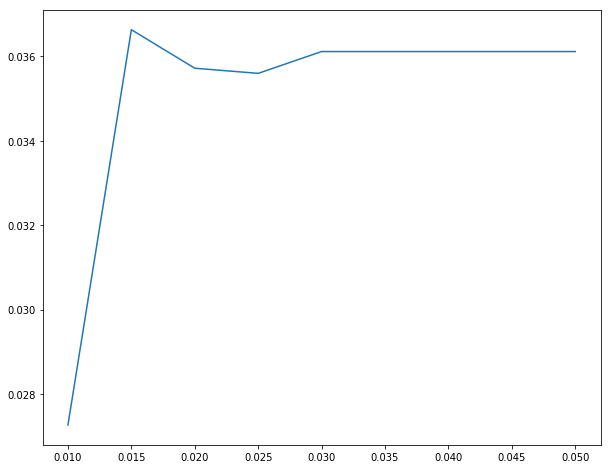

[0.027266222947131526,
 0.03663349229485031,
 0.035720779371761706,
 0.03559863286283649,
 0.03611565060383603,
 0.03611565060383603,
 0.03611565060383603,
 0.03611565060383603,
 0.03611565060383603]

In [24]:
profits = opt.opt_cut_conserv(cuts, initial)
profits

In [11]:
initials = np.array(range(1,7)) * 5000
cuts = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07]

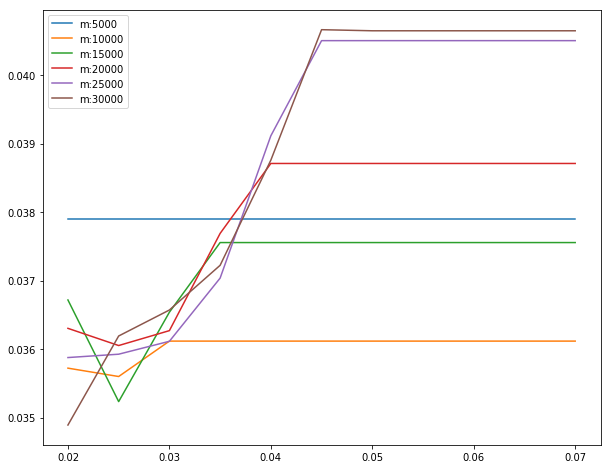

[{'initialInvest': 5000, 'cut': 0.02, 'return': 0.037899778263759384},
 {'initialInvest': 10000, 'cut': 0.03, 'return': 0.03611565060383603},
 {'initialInvest': 15000, 'cut': 0.035, 'return': 0.03755416475953966},
 {'initialInvest': 20000, 'cut': 0.04, 'return': 0.03870881733651747},
 {'initialInvest': 25000, 'cut': 0.045, 'return': 0.04050190752505754},
 {'initialInvest': 30000, 'cut': 0.045, 'return': 0.04066188178959241}]

In [12]:
profits = opt.opt_seed_conserv(cuts, initials)
profits

### 7.2 Aggresive Strategy

3.6% is not too bad, but we can probably do better by simply improving the investment strategy, not the prediction model. So let's explore other strategies here. For the first, we tried the strategy taking risk slightly more agressively, which invest based on the expected return.

In [54]:
strat = investment.StrategyClassComplex(xgb)
print(strat.description())

This strategy chooses loans basaed on the expected payoff. The expected payoff is calculated by the interest rate minus the model score. If the calculated expected payoff is greater than the predefined cut, then it selects a loan. It further filters out the selected loan by FICO score and the loan grade.


In [55]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

Based on the backtesting results, if we invest USD 10K, then we can expect 5.98% when we limit the loans above expected resutn 0.1 and below "C2" grade. This is reasonable profit.

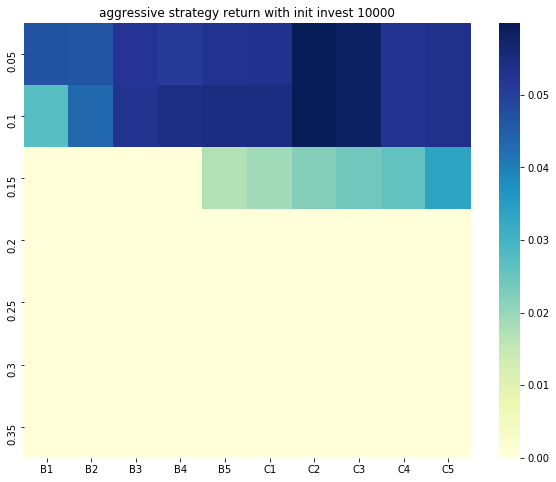

,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5
0.05,0.046757,0.046488,0.052236,0.051169,0.052945,0.053298,0.059871,0.058351,0.052739,0.053493
0.10,0.027176,0.043353,0.052713,0.054116,0.054553,0.054653,0.059871,0.058351,0.052739,0.053493
0.15,0.000000,0.000000,0.000000,0.000000,0.017206,0.019085,0.021954,0.024019,0.025963,0.033458
0.20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
initial = 10000
grades = ["B1", "B2", "B3", "B4", "B5", "C1", "C2", "C3", "C4", "C5"]
cuts = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

profits = opt.opt_cut_aggr(cuts, grades, initial, plot=True)
profits

Let's explore further, whether we can get the better return if we invest more. The best parameter still remains at 0.1 and "C2" (or "C3" with minor difference). The reason of dereasing profit is due to the holding period. If we look at the investment amounts by month, entire funding cannot invested at first month if funding is larger than 10000. This is why the profit seems to be deteriorated (due to additional discounting). In other words, this does not inndicate the deteriorate of strategy. If we run the strategy long enough, than the difference will be faded out. 

10000


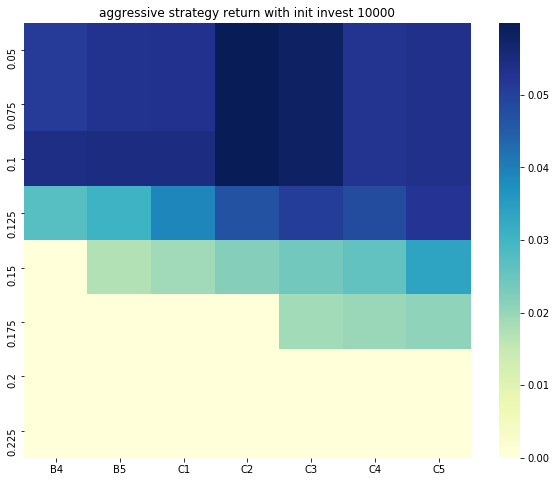

20000


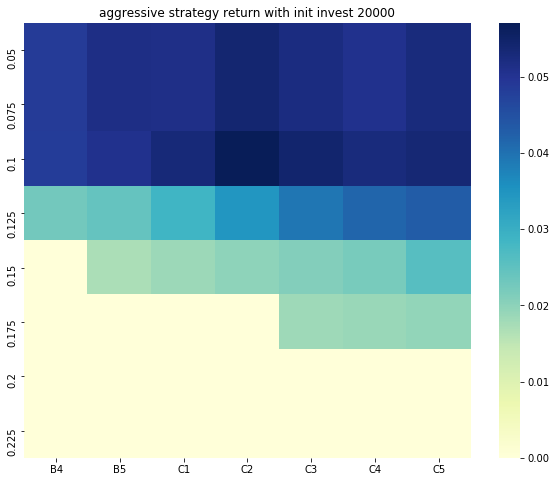

30000


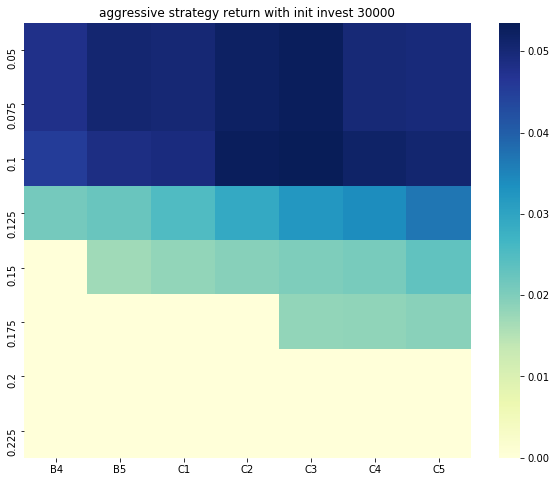

[{'return': 0.059871029507463015,
  'initialInvest': 10000,
  'grade': 'C2',
  'cut': 0.05},
 {'return': 0.05706998984005257,
  'initialInvest': 20000,
  'grade': 'C2',
  'cut': 0.1},
 {'return': 0.05347915814058515,
  'initialInvest': 30000,
  'grade': 'C3',
  'cut': 0.1}]

In [58]:
initials = np.array(range(1,4)) * 10000
grades = ["B4", "B5", "C1", "C2", "C3", "C4", "C5"]
cuts = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225]

profits = opt.opt_seed_aggr(cuts, grades, initials, plot=True)
profits

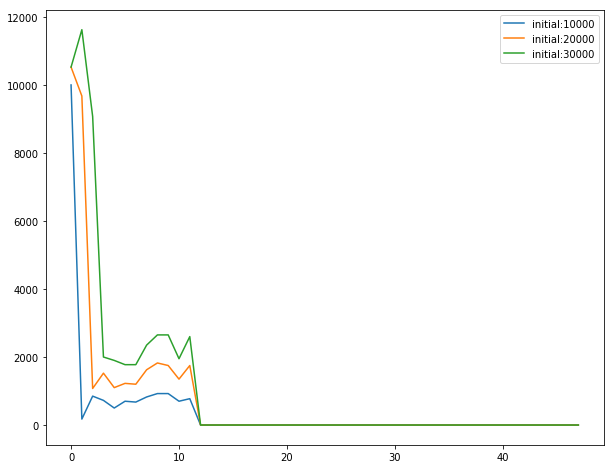

In [68]:
plt.figure(figsize=(10,8))
seeds = [10000, 20000, 30000]
for seed in seeds:
    strat.cut = 0.1
    strat.grade = "C2"
    tester = backtester.Backtester(DataHelper, xgb, strat, 1)
    tester.initialInvest = seed
    total, C, l, profit = tester.backtest(DataHelper.test, returnAll = True)
    plt.plot(l)

plt.legend(["initial:{}".format(x) for x in seeds], loc='upper right')
plt.show()

In [73]:
summary = total[["sub_grade", "bad_loan"]].groupby(["sub_grade"]).agg("sum")
summary["count"] = total[["sub_grade", "int_rate"]].groupby(["sub_grade"]).agg("count")
summary["rate"] = summary["bad_loan"]/summary["count"]
summary

,bad_loan,count,rate
sub_grade,,,
A3,0.0,4,0.000000
A4,0.0,6,0.000000
A5,0.0,30,0.000000
B1,3.0,45,0.066667
B2,8.0,126,0.063492
B3,13.0,296,0.043919
B4,25.0,319,0.078370
B5,24.0,324,0.074074
C1,34.0,430,0.079070


## Aggressive Strategy with adjusted amounts

Can we do better? We can probably increase the profit by adjusting investment amounts for each loan based on the expected retrn. Let's explore the strategy here. We will stick to the parameter 0.1 and "C2". However, we will adjust invest amount by using logistic function on expected return. The slope and maximum of the function will be finetuned through backtesting.

It marginally increases the profits. However, it also added large uncertainty, since the optimal parameters shifted a lot depending on the initial amount invested. Therefore, adjusting amounts does not seem to be necessary in our strategy.

In [7]:
strat = investment.StrategyClassComplexII(xgb)
print(strat.description())

This strategy chooses loans basaed on the expected payoff. The expected payoff is calculated by the interest rate minus the model score. If the calculated expected payoff is greater than the predefined cut, then it selects a loan. It also increase the invest amount for each loan based on the payoff. It further filters out the selected loan by FICO score and the loan grade.


In [8]:
opt = investment.StrategyOptimizer(DataHelper, xgb, strat)

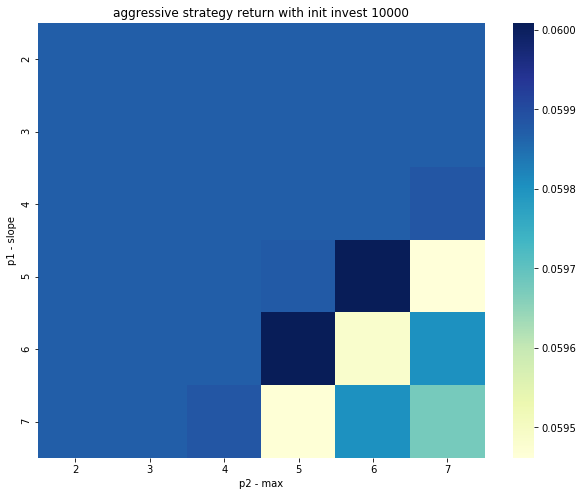

,2,3,4,5,6,7
2,0.059871,0.059871,0.059871,0.059871,0.059871,0.059871
3,0.059871,0.059871,0.059871,0.059871,0.059871,0.059871
4,0.059871,0.059871,0.059871,0.059871,0.059871,0.059884
5,0.059871,0.059871,0.059871,0.059877,0.060009,0.059462
6,0.059871,0.059871,0.059871,0.060009,0.059484,0.059802
7,0.059871,0.059871,0.059884,0.059467,0.059802,0.059676


In [9]:
initial = 10000
slopes = list(range(2,8))
maxs = list(range(2,8))

profits = opt.opt_amountfunc_aggr(slopes, maxs, 0.1, "C2", initial, plot=True)
profits

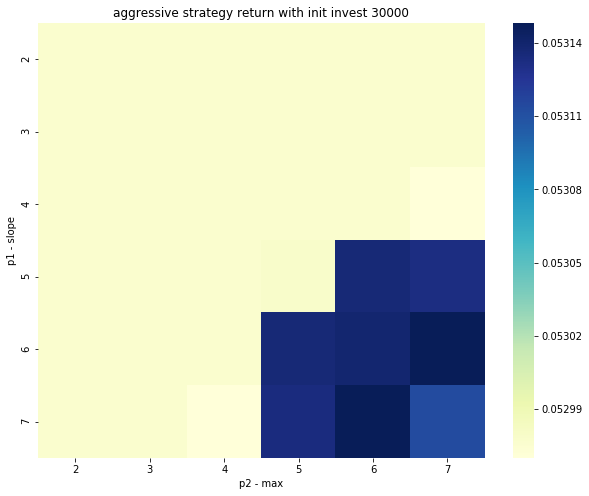

,2,3,4,5,6,7
2,0.052977,0.052977,0.052977,0.052977,0.052977,0.052977
3,0.052977,0.052977,0.052977,0.052977,0.052977,0.052977
4,0.052977,0.052977,0.052977,0.052977,0.052977,0.052970
5,0.052977,0.052977,0.052977,0.052979,0.053137,0.053132
6,0.052977,0.052977,0.052977,0.053137,0.053139,0.053148
7,0.052977,0.052977,0.052970,0.053134,0.053148,0.053114


In [10]:
initial = 30000
slopes = list(range(2,8))
maxs = list(range(2,8))

profits = opt.opt_amountfunc_aggr(slopes, maxs, 0.1, "C2", initial, plot=True)
profits

Until here, let's run

In [11]:
strat.amount_slope = 6
strat.amount_max = 5
strat.cut = 0.1
strat.grade = "C2"

tester = backtester.Backtester(DataHelper, xgb, strat, 1)
tester.initialInvest = 10000
total, C, l, profit = tester.backtest(DataHelper.test, returnAll = True)

 # sort by expected payoff
int_rate = total["int_rate"] / 12
int_rate = np.array([sum(x * np.array([1-i*1/36 for i in range(0, 36)])) for x in int_rate])
expected = int_rate - total["score"]
expected = np.sort(expected)

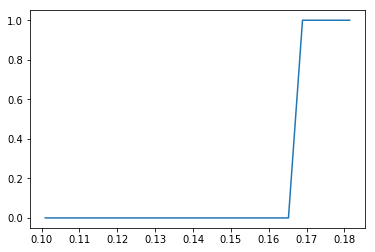

In [12]:
amounts = strat.amounts_func(expected)
plt.plot(expected, amounts)

In [13]:
strat.amount_slope = 7
strat.amount_max = 6
strat.cut = 0.1
strat.grade = "C2"

tester = backtester.Backtester(DataHelper, xgb, strat, 1)
tester.initialInvest = 30000
total, C, l, profit = tester.backtest(DataHelper.test, returnAll = True)

 # sort by expected payoff
int_rate = total["int_rate"] / 12
int_rate = np.array([sum(x * np.array([1-i*1/36 for i in range(0, 36)])) for x in int_rate])
expected = int_rate - total["score"]
expected = np.sort(expected)

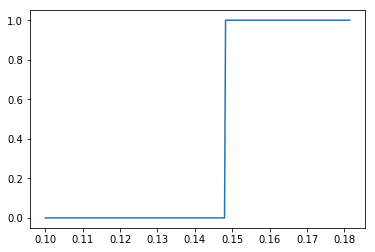

In [14]:
amounts = strat.amounts_func(expected)
plt.plot(expected, amounts)

## Summary

As we can see, the Aggressive strategy performs well producing ~6% annulized return. The strategy we are going to use is the Aggressive one based on the 0.1 cut and "C2" grade. We will not adjust investment money for each loans.

Please note that the key of our profit is really in the prediction model. Improving AUC will end up with higher profits.